# Heat Pump COP Time Series Generation: Ruhnau Method

This notebook demonstrates how to use the Ruhnau method to generate heat pump COP time series for different heat pump types, heating systems, and domestic hot water (DHW).

The Ruhnau method is based on the paper by Ruhnau et al. (2019) "Time series of heat demand and heat pump efficiency for energy system modeling".


## Imports

Import required libraries and set visualization defaults.


In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from entise.constants import Types
from entise.core.generator import TimeSeriesGenerator as TSGen

%matplotlib inline


## Load Data

We load the heat pump parameters from `objects.csv` and simulation data from the `data` folder.


In [2]:
cwd = "."  # Current working directory: change if your kernel is not running in the same folder
objects = pd.read_csv(os.path.join(cwd, "objects.csv"))
data = {}
data_folder = "data"
common_data_folder = "../common_data"
for file in os.listdir(os.path.join(cwd, common_data_folder)):
    if file.endswith(".csv"):
        name = file.split(".")[0]
        data[name] = pd.read_csv(os.path.join(os.path.join(cwd, common_data_folder, file)), parse_dates=True)
for file in os.listdir(os.path.join(cwd, data_folder)):
    if file.endswith(".csv"):
        name = file.split(".")[0]
        data[name] = pd.read_csv(os.path.join(os.path.join(cwd, data_folder, file)), parse_dates=True)
    elif file.endswith(".json"):
        name = file.split(".")[0]
        with open(os.path.join(os.path.join(cwd, data_folder, file)), "r") as f:
            data[name] = json.load(f)

print("Loaded data keys:", list(data.keys()))


Loaded data keys: ['weather', 'system']


## Display Objects

Let's take a look at the heat pump objects we've loaded.


In [3]:
# Display the objects
objects


,id,hp,weather,hp_source,hp_sink,sink_temperature[C],gradient_sink,water_temperature[C],correction_factor,hp_system
0,1,ruhnau,weather,air,radiator,50.0,-1.0,50.0,NaN,NaN
1,2,ruhnau,weather,soil,floor,30.0,-0.5,55.0,NaN,NaN
2,3,ruhnau,weather,water,radiator,35.0,-1.0,60.0,NaN,NaN
3,4,ruhnau,weather,NaN,floor,25.0,-0.5,NaN,NaN,NaN
4,5,ruhnau,weather,air,floor,35.0,NaN,NaN,NaN,NaN
5,6,ruhnau,weather,soil,radiator,NaN,NaN,NaN,NaN,NaN
6,7,ruhnau,weather,water,floor,NaN,NaN,NaN,NaN,NaN
7,8,ruhnau,weather,NaN,NaN,NaN,NaN,NaN,0.95,system


## Instantiate and Configure Model

Initialize the time series generator and add the objects.


In [4]:
gen = TSGen()
gen.add_objects(objects)


## Run the Simulation

Generate heat pump COP time series for each object.


In [5]:
summary, df = gen.generate(data, workers=1)


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


## Results Summary

Below is a summary of the COP values for each heat pump system.


In [6]:
print("Summary:")
summary


Summary:


,hp_heating_avg,hp_heating_min,hp_heating_max,hp_dhw_avg,hp_dhw_min,hp_dhw_max
1,3.53,1.97,7.40,2.88,2.16,4.30
2,7.31,5.22,10.27,3.30,2.72,3.98
3,7.16,4.50,11.81,2.89,2.89,2.89
4,4.66,2.91,8.01,2.88,2.16,4.30
5,4.01,2.51,7.02,2.88,2.16,4.30
6,6.71,3.72,11.99,3.82,3.17,4.56
7,7.00,5.61,9.15,3.77,3.77,3.77
8,5.06,2.95,9.89,3.69,2.89,5.28


## Preparation for Visualization

Before we create visualizations, we need to prepare the data.


In [7]:
# Convert index to datetime for all time series
for obj_id in df:
    if Types.HP in df[obj_id]:
        df[obj_id][Types.HP].index = pd.to_datetime(df[obj_id][Types.HP].index, utc=True)

# Get heat pump parameters from objects dataframe
system_configs = {}
for _, row in objects.iterrows():
    obj_id = row['id']
    if obj_id in df:
        hp_source = row['hp_source'] if not pd.isna(row.get('hp_source', pd.NA)) else "Default"
        hp_sink = row['hp_sink'] if not pd.isna(row.get('hp_sink', pd.NA)) else "Default"
        temp_sink = row['temp_sink'] if not pd.isna(row.get('temp_sink', pd.NA)) else "Default"
        temp_water = row['temp_water'] if not pd.isna(row.get('temp_water', pd.NA)) else "Default"
        system_configs[obj_id] = {
            'hp_source': hp_source,
            'hp_sink': hp_sink,
            'temp_sink': temp_sink,
            'temp_water': temp_water
        }


## Visualization 1: COP Distribution by System

Let's compare the distribution of COP values for different heat pump systems using boxplots.


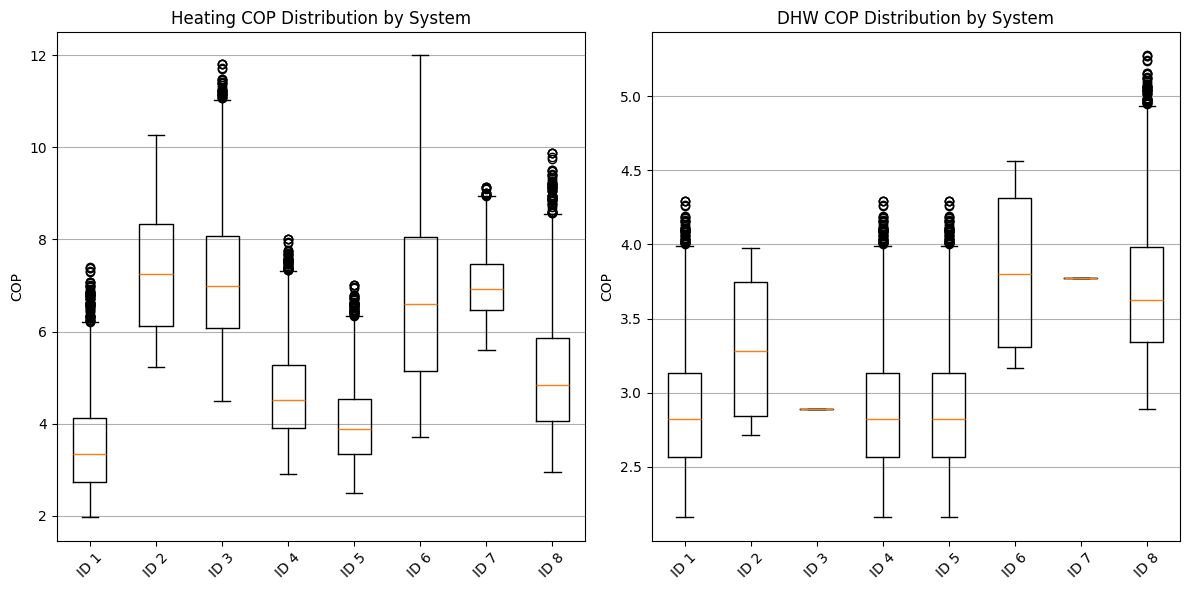

In [8]:
# Collect the full distribution of COP values for each system
heating_cop_data = []
dhw_cop_data = []
system_ids = []

for obj_id in df:
    if Types.HP in df[obj_id]:
        # Extract heating COP
        heating_col = f"{Types.HP}_{Types.HEATING}"
        if heating_col in df[obj_id][Types.HP].columns:
            heating_cop_data.append(df[obj_id][Types.HP][heating_col].values)

            # Only add system ID if we haven't already (to keep lists aligned)
            if len(heating_cop_data) > len(system_ids):
                system_ids.append(obj_id)

        # Extract DHW COP
        dhw_col = f"{Types.HP}_{Types.DHW}"
        if dhw_col in df[obj_id][Types.HP].columns:
            dhw_cop_data.append(df[obj_id][Types.HP][dhw_col].values)

# Create a boxplot for heating COP distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.boxplot(heating_cop_data, labels=[f"ID {id}" for id in system_ids])
plt.title("Heating COP Distribution by System")
plt.ylabel("COP")
plt.xticks(rotation=45)
plt.grid(axis="y")

# Create a boxplot for DHW COP distribution
plt.subplot(1, 2, 2)
plt.boxplot(dhw_cop_data, labels=[f"ID {id}" for id in system_ids])
plt.title("DHW COP Distribution by System")
plt.ylabel("COP")
plt.xticks(rotation=45)
plt.grid(axis="y")

plt.tight_layout()
plt.show()


## Visualization 2: Time Series for All Systems

Let's visualize the COP time series for all heat pump systems.


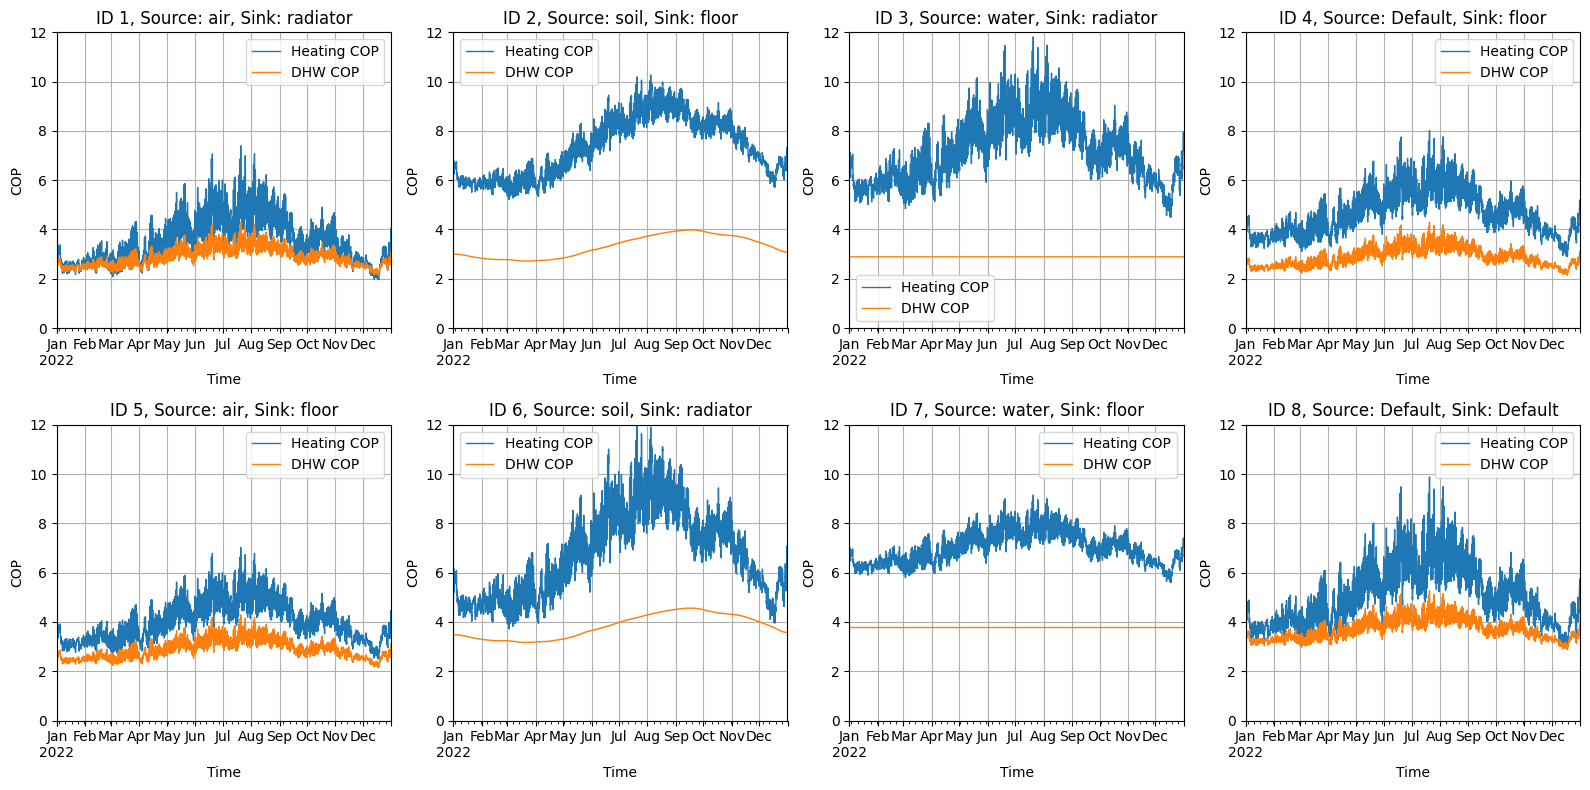

In [9]:
# Calculate the number of rows and columns for the subplots
n_systems = len(df)
n_cols = min(4, n_systems)
n_rows = (n_systems + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
# Always flatten the axes array to make it easier to index
if n_rows == 1 and n_cols == 1:
    axes = np.array([axes])  # Make axes iterable if there's only one subplot
else:
    axes = axes.flatten()  # Flatten the array of axes for easier indexing

# For each heat pump system, create a separate subplot
for i, obj_id in enumerate(df):
    if i >= len(axes):
        break  # Safety check
    
    if Types.HP not in df[obj_id]:
        continue
    
    # Get system parameters for the title
    config = system_configs.get(obj_id, {})
    hp_source = config.get('hp_source', 'Default')
    hp_sink = config.get('hp_sink', 'Default')
    temp_sink = config.get('temp_sink', 'Default')
    temp_water = config.get('temp_water', 'Default')
    
    # Plot the heating COP time series
    heating_col = f"{Types.HP}_{Types.HEATING}"
    if heating_col in df[obj_id][Types.HP].columns:
        df[obj_id][Types.HP][heating_col].plot(ax=axes[i], color='#1f77b4', linewidth=1, label='Heating COP')
    
    # Plot the DHW COP time series
    dhw_col = f"{Types.HP}_{Types.DHW}"
    if dhw_col in df[obj_id][Types.HP].columns:
        df[obj_id][Types.HP][dhw_col].plot(ax=axes[i], color='#ff7f0e', linewidth=1, label='DHW COP')
    
    axes[i].set_title(f'ID {obj_id}, Source: {hp_source}, Sink: {hp_sink}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('COP')
    axes[i].set_ylim(0, 12)
    axes[i].legend()
    axes[i].grid(True)

# Hide empty subplots
for i in range(len(df), len(axes)):
    if i < len(axes):
        axes[i].axis('off')

plt.tight_layout()
plt.show()


## Visualization 3: COP Heatmap (Heating Only)

Let's create a heatmap visualization to show how heating COP varies by hour of day and day of year.


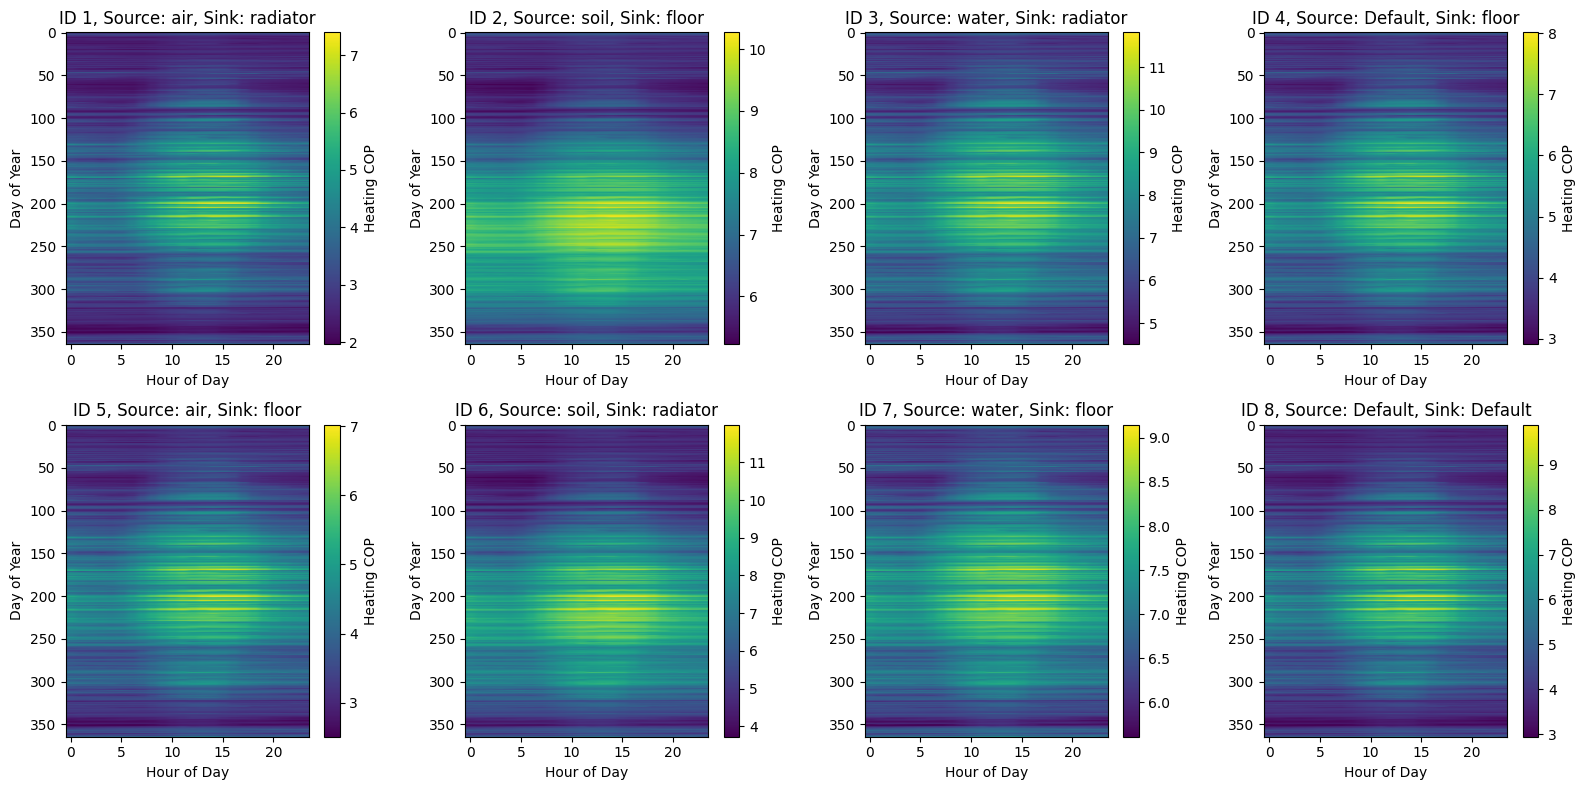

In [10]:
# Create a figure with appropriate number of subfigures
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
# Always flatten the axes array to make it easier to index
if n_rows == 1 and n_cols == 1:
    axes = np.array([axes])  # Make axes iterable if there's only one subplot
else:
    axes = axes.flatten()  # Flatten the array of axes for easier indexing

# For each heat pump system, create a separate subplot
for i, obj_id in enumerate(df):
    if i >= len(axes):
        break  # Safety check
    
    if Types.HP not in df[obj_id]:
        continue
    
    # Get system parameters for the title
    config = system_configs.get(obj_id, {})
    hp_source = config.get('hp_source', 'Default')
    hp_sink = config.get('hp_sink', 'Default')
    
    # Process heating COP
    heating_col = f"{Types.HP}_{Types.HEATING}"
    if heating_col in df[obj_id][Types.HP].columns:
        ts = df[obj_id][Types.HP][heating_col]
        
        # Create a pivot table with hours as columns and days as rows
        pivot_data = pd.DataFrame({
            'hour': ts.index.hour,
            'day_of_year': ts.index.dayofyear,
            'cop': ts.values
        })
        pivot_table = pivot_data.pivot_table(values='cop', index='day_of_year', columns='hour', aggfunc='mean')
        
        # Create heatmap
        im = axes[i].imshow(pivot_table, aspect='auto', cmap='viridis')
        axes[i].set_title(f'ID {obj_id}, Source: {hp_source}, Sink: {hp_sink}')
        axes[i].set_xlabel('Hour of Day')
        axes[i].set_ylabel('Day of Year')
        
        # Add colorbar
        fig.colorbar(im, ax=axes[i], label='Heating COP')

# Hide empty subplots
for i in range(len(df), len(axes)):
    if i < len(axes):
        axes[i].axis('off')

plt.tight_layout()
plt.show()


## Visualization 4: Seasonal Daily Profile Analysis

Let's analyze how COP values vary throughout the day for different seasons.


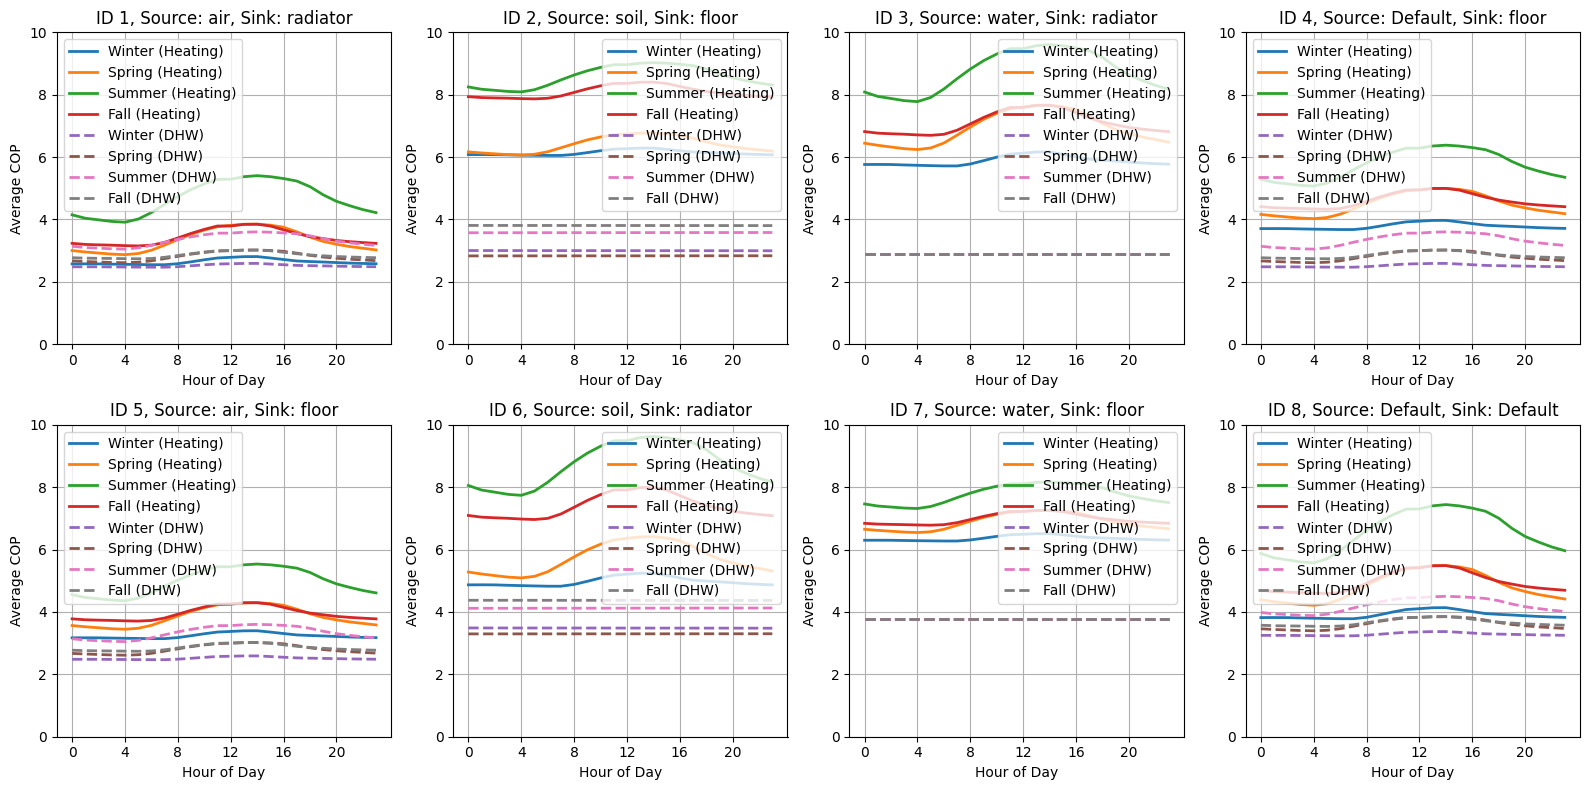

In [11]:
# Define seasons
seasons = {
    'Winter': [12, 1, 2],
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Fall': [9, 10, 11]
}

# Create a figure with appropriate number of subfigures
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
# Always flatten the axes array to make it easier to index
if n_rows == 1 and n_cols == 1:
    axes = np.array([axes])  # Make axes iterable if there's only one subplot
else:
    axes = axes.flatten()  # Flatten the array of axes for easier indexing

# For each heat pump system, create a separate subplot
for i, obj_id in enumerate(df):
    if i >= len(axes):
        break  # Safety check
    
    if Types.HP not in df[obj_id]:
        continue
    
    # Get system parameters for the title
    config = system_configs.get(obj_id, {})
    hp_source = config.get('hp_source', 'Default')
    hp_sink = config.get('hp_sink', 'Default')
    
    # Process heating COP
    heating_col = f"{Types.HP}_{Types.HEATING}"
    if heating_col in df[obj_id][Types.HP].columns:
        ts_heating = df[obj_id][Types.HP][heating_col]
        
        # Plot each season on the same subplot
        for season_name, months in seasons.items():
            # Filter data for the season
            season_data = ts_heating[ts_heating.index.month.isin(months)]
            if not season_data.empty:
                # Create average daily profile
                daily_profile = season_data.groupby(season_data.index.hour).mean()
                axes[i].plot(daily_profile.index, daily_profile.values, label=f'{season_name} (Heating)', linewidth=2)
    
    # Process DHW COP
    dhw_col = f"{Types.HP}_{Types.DHW}"
    if dhw_col in df[obj_id][Types.HP].columns:
        ts_dhw = df[obj_id][Types.HP][dhw_col]
        
        # Plot each season on the same subplot (using dashed lines for DHW)
        for season_name, months in seasons.items():
            # Filter data for the season
            season_data = ts_dhw[ts_dhw.index.month.isin(months)]
            if not season_data.empty:
                # Create average daily profile
                daily_profile = season_data.groupby(season_data.index.hour).mean()
                axes[i].plot(daily_profile.index, daily_profile.values, label=f'{season_name} (DHW)', 
                             linewidth=2, linestyle='--')

    axes[i].set_title(f'ID {obj_id}, Source: {hp_source}, Sink: {hp_sink}')
    axes[i].set_xlabel('Hour of Day')
    axes[i].set_ylabel('Average COP')
    axes[i].set_ylim(0, 10)
    axes[i].legend()
    axes[i].grid(True)
    axes[i].set_xticks(range(0, 24, 4))  # Show fewer ticks for readability

# Hide empty subplots
for i in range(len(df), len(axes)):
    if i < len(axes):
        axes[i].axis('off')

plt.tight_layout()
plt.show()


## Visualization 5: COP vs. Temperature Analysis

Let's analyze the relationship between COP and outdoor temperature.


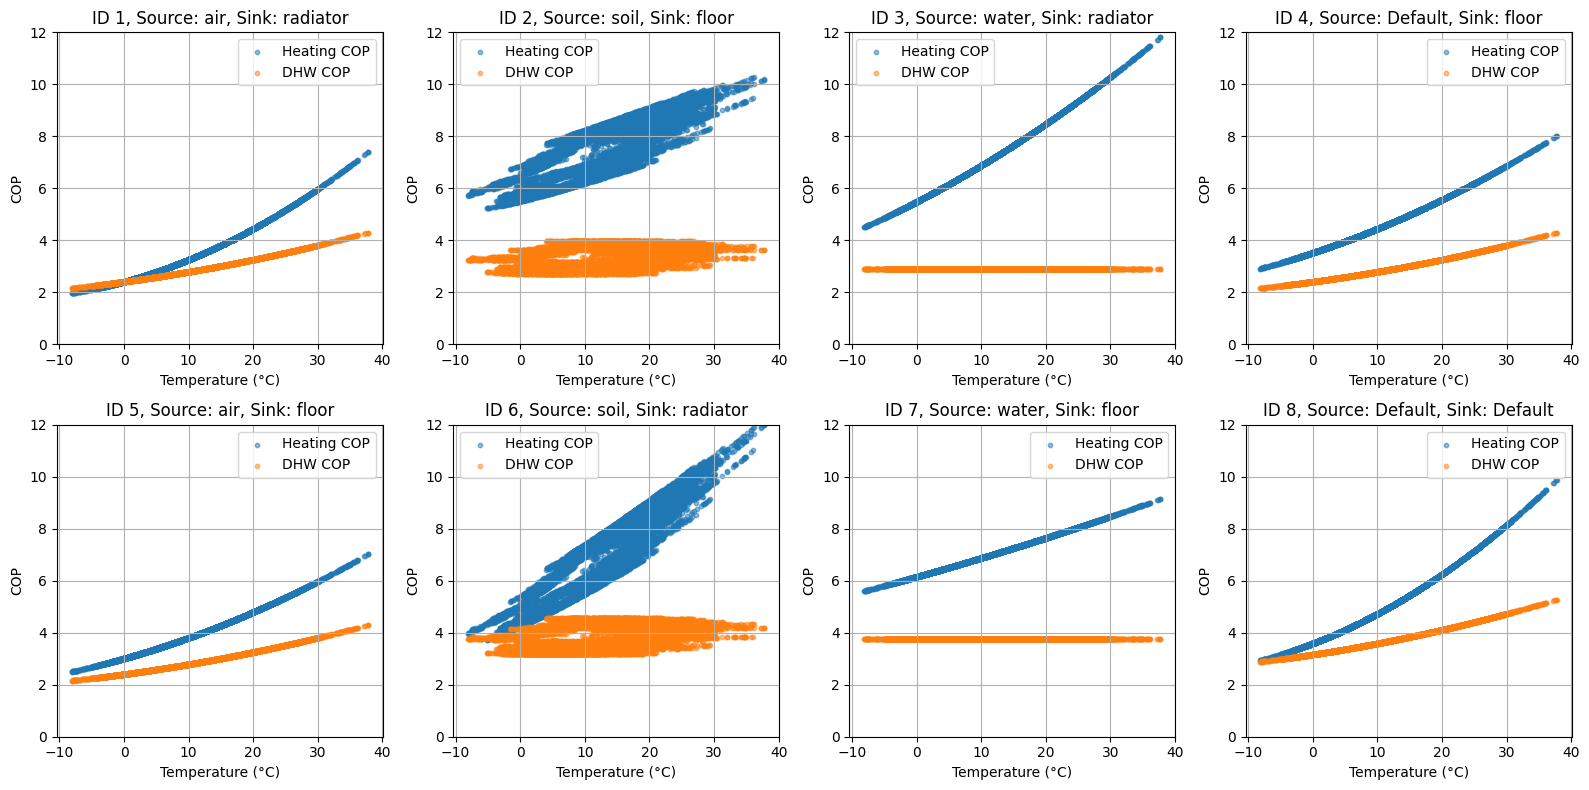

In [12]:
# Create a figure with appropriate number of subfigures
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
# Always flatten the axes array to make it easier to index
if n_rows == 1 and n_cols == 1:
    axes = np.array([axes])  # Make axes iterable if there's only one subplot
else:
    axes = axes.flatten()  # Flatten the array of axes for easier indexing

# For each heat pump system, create a separate subplot
for i, obj_id in enumerate(df):
    if i >= len(axes):
        break  # Safety check

    if Types.HP not in df[obj_id]:
        continue

    # Get system parameters for the title
    config = system_configs.get(obj_id, {})
    hp_source = config.get("hp_source", "Default")
    hp_sink = config.get("hp_sink", "Default")

    # Get weather data
    weather_data = data.get("weather")
    if weather_data is None:
        continue

    # Ensure weather data has the same index as the COP data
    # Check if the index is already a datetime index
    if not isinstance(weather_data.index, pd.DatetimeIndex):
        # Check if 'datetime' column exists
        if "datetime" in weather_data.columns:
            weather_data["datetime"] = pd.to_datetime(weather_data["datetime"], utc=True)
            weather_data.set_index("datetime", inplace=True)
        # If not, check if the index can be converted to datetime
        else:
            try:
                weather_data.index = pd.to_datetime(weather_data.index, utc=True)
            except:
                # If all else fails, try to find a column that looks like a datetime
                datetime_cols = [col for col in weather_data.columns if "time" in col.lower() or "date" in col.lower()]
                if datetime_cols:
                    weather_data[datetime_cols[0]] = pd.to_datetime(weather_data[datetime_cols[0]], utc=True)
                    weather_data.set_index(datetime_cols[0], inplace=True)
                else:
                    # If no datetime column is found, skip this iteration
                    continue

    # Get temperature column
    temp_col = "air_temperature[C]"

    # Process heating COP
    heating_col = f"{Types.HP}_{Types.HEATING}"
    if heating_col in df[obj_id][Types.HP].columns:
        # Merge COP and temperature data
        merged_data = pd.merge(
            df[obj_id][Types.HP][heating_col],
            weather_data[temp_col],
            left_index=True,
            right_index=True,
            how="inner",
        )

        # Plot scatter plot
        axes[i].scatter(merged_data[temp_col], merged_data[heating_col], label="Heating COP", alpha=0.5, s=10)

    # Process DHW COP
    dhw_col = f"{Types.HP}_{Types.DHW}"
    if dhw_col in df[obj_id][Types.HP].columns:
        # Merge COP and temperature data
        merged_data = pd.merge(
            df[obj_id][Types.HP][dhw_col],
            weather_data[temp_col],
            left_index=True,
            right_index=True,
            how="inner",
        )

        # Plot scatter plot
        axes[i].scatter(merged_data[temp_col], merged_data[dhw_col], label="DHW COP", alpha=0.5, s=10)

    axes[i].set_title(f"ID {obj_id}, Source: {hp_source}, Sink: {hp_sink}")
    axes[i].set_xlabel("Temperature (°C)")
    axes[i].set_ylabel("COP")
    axes[i].set_ylim(0, 12)
    axes[i].legend()
    axes[i].grid(True)

# Hide empty subplots
for i in range(len(df), len(axes)):
    if i < len(axes):
        axes[i].axis("off")

plt.tight_layout()
plt.show()


## Conclusion

In this notebook, we've demonstrated how to use the Ruhnau method to generate heat pump COP time series for different heat pump types, heating systems, and domestic hot water (DHW). We've also visualized the results in various ways to gain insights into the performance of different heat pump systems.

You can further explore:
- Adjusting heat pump parameters in `objects.csv`
- Testing different system configurations
- Analyzing the impact of temperature on COP values
- Comparing performance across different seasons